# Price Prediction using RNN - LSTM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
csv_filepath:str = "../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv"
print(f"csv_filepath {csv_filepath}")
date_column:str = "Date "
open_column:str = "OPEN "
high_column:str = "HIGH "
low_column:str = "LOW "
close_column:str = "close "
volume_column:str = "VOLUME "
date_column_index:int = 3
np.set_printoptions(suppress=True)

csv_filepath ../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv


In [3]:
df = pd.read_csv(csv_filepath, date_parser=True, header=0)
print(f"df keys")
print(f"{df.keys()}")
# Sort DataFrame by date
df[date_column]=pd.to_datetime(df[date_column])
df.head()

df keys
Index(['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ',
       'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ',
       'No of trades '],
      dtype='object')


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2020-08-19,EQ,"1,835.00","1,835.90","1,818.05","1,820.70","1,827.55","1,827.95","1,828.01","2,499.90","1,473.45",2934730,"5,364,712,976.60",85358
1,2020-08-18,EQ,"1,801.10","1,825.40","1,795.95","1,800.55","1,819.05","1,820.70","1,813.53","2,499.90","1,473.45",3413536,"6,190,549,505.40",141811
2,2020-08-17,EQ,"1,805.00","1,807.85","1,783.85","1,791.70","1,801.95","1,800.55","1,795.17","2,499.90","1,473.45",4076960,"7,318,829,944.15",148103
3,2020-08-14,EQ,"1,818.60","1,823.75","1,773.25","1,804.85","1,793.75","1,791.70","1,796.65","2,499.90","1,473.45",6136766,"11,025,637,096.85",186319
4,2020-08-13,EQ,"1,818.50","1,823.65","1,799.55","1,814.20","1,810.00","1,804.85","1,807.52","2,499.90","1,473.45",3769538,"6,813,503,042.60",129725


In [4]:
df[date_column] = pd.to_datetime(df[date_column]).astype('datetime64[ns]')
df[open_column] = df[open_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[high_column] = df[high_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[low_column] = df[low_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[close_column] = df[close_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[volume_column] = df[volume_column].transform(func=lambda x: "".join(str(x).split(","))).astype(int)
df = df[[date_column, open_column, high_column, low_column, close_column, volume_column]]
df = df.sort_values(by=[date_column], ascending=True)
df.head()

,Date,OPEN,HIGH,LOW,close,VOLUME
485,2018-08-29,1959.4,1971.40,1944.70,1956.25,2367281
484,2018-08-30,1950.0,1964.45,1928.25,1934.15,2466442
483,2018-08-31,1940.9,1942.45,1908.05,1935.95,3856093
482,2018-09-03,1950.0,1950.00,1928.10,1944.80,2310201
481,2018-09-04,1939.0,1959.65,1939.00,1954.80,2928533


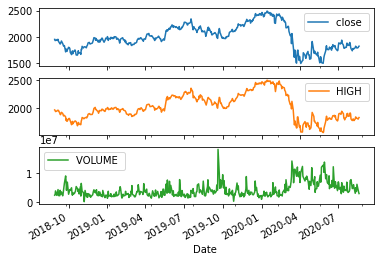

In [5]:
date_time = pd.to_datetime(df[date_column], format='%Y-%m-%d')

plot_cols = [close_column, high_column, volume_column]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [6]:
df = df.drop([date_column], axis=1)
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.65):int(n*0.99)]
test_df = df[int(n*0.85):]
train_df

,OPEN,HIGH,LOW,close,VOLUME
485,1959.40,1971.40,1944.70,1956.25,2367281
484,1950.00,1964.45,1928.25,1934.15,2466442
483,1940.90,1942.45,1908.05,1935.95,3856093
482,1950.00,1950.00,1928.10,1944.80,2310201
481,1939.00,1959.65,1939.00,1954.80,2928533
...,...,...,...,...,...
150,2461.10,2471.05,2441.00,2462.55,3401754
149,2463.65,2499.90,2446.60,2492.30,2549328
148,2483.95,2495.00,2453.55,2488.60,2279961
147,2486.00,2495.75,2471.80,2482.10,1794295


In [7]:
scaler = MinMaxScaler()
scaled_train_df = scaler.fit_transform(train_df)
scaled_train_df

array([[0.37384067, 0.34769193, 0.36286716, 0.3572542 , 0.12405331],
       [0.3626635 , 0.3391138 , 0.3429832 , 0.3307554 , 0.12953814],
       [0.35184304, 0.31196001, 0.31856642, 0.33291367, 0.20640306],
       ...,
       [0.99756243, 0.99395211, 0.97794029, 0.99556355, 0.11922343],
       [1.        , 0.99487781, 1.        , 0.98776978, 0.09236008],
       [0.97829964, 0.9742039 , 0.97153391, 0.95401679, 0.11759039]])

In [8]:
X_train = []
Y_train = []
window_size = 60
for i in range(window_size, scaled_train_df.shape[0]):
    X_train.append(scaled_train_df[i-window_size: i])
    Y_train.append(scaled_train_df[i])

In [9]:
x_train = np.array(X_train)
y_train = np.array(Y_train)
x_train.shape, y_train.shape

((280, 60, 5), (280, 5))

## Building LSTM

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [11]:
model = Sequential()
model.add(LSTM(units=240, activation="tanh", return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=120, activation="tanh", return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation="tanh", return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=30, activation="tanh"))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 240)           236160    
_________________________________________________________________
dropout (Dropout)            (None, 60, 240)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 120)           173280    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 60)            43440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                1

In [12]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError())

In [13]:
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
9/9 [==============================] - 1s 128ms/step - loss: 0.0692
Epoch 2/50
9/9 [==============================] - 1s 123ms/step - loss: 0.0404

### Validation

In [14]:
val_past_60_days = train_df.tail(window_size)
val_df = val_past_60_days.append(val_df, ignore_index=True)
val_df.head()

,OPEN,HIGH,LOW,close,VOLUME
0,2150.00,2174.20,2141.35,2144.95,4061508
1,2149.00,2153.45,2085.25,2101.55,3099190
2,2114.95,2120.00,2096.80,2105.35,280920
3,2095.00,2123.55,2079.05,2113.05,2732339
4,2134.95,2134.95,2102.60,2107.45,2347585


In [15]:
scaled_val_df = scaler.transform(val_df)
scaled_val_df.shape

(226, 5)

In [16]:
X_val = []
Y_val = []
for i in range(window_size, scaled_val_df.shape[0]):
    X_val.append(scaled_val_df[i-window_size: i])
    Y_val.append(scaled_val_df[i])

In [17]:
x_val = np.array(X_val)
y_val = np.array(Y_val)
x_val.shape, y_val.shape

((166, 60, 5), (166, 5))

In [18]:
y_val_predicted = model.predict(x_val)
y_val_predicted.shape

(166, 1)

In [19]:
scaler.scale_

array([0.00118906, 0.00123426, 0.00120875, 0.00119904, 0.00000006])

In [20]:
scale = 1 / scaler.scale_
scale, scaler.data_min_, scaler.data_max_


(array([     841. ,      810.2,      827.3,      834. , 18079131. ]),
 array([  1645. ,   1689.7,   1644.5,   1658.3, 124505. ]),
 array([    2486. ,     2499.9,     2471.8,     2492.3, 18203636. ]))

In [21]:
Y_predicted = y_val_predicted*scale[date_column_index] + scaler.data_min_[date_column_index]
Y_values = scaler.inverse_transform(scaled_val_df)
Y_actual = Y_values[:, date_column_index][window_size:]
Y_predicted.shape, Y_actual.shape

((166, 1), (166,))

## Visualization

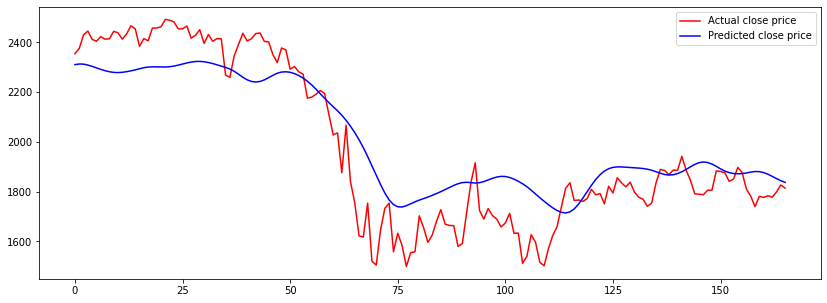

In [22]:
plt.figure(figsize=(14,5))
plt.plot(Y_actual, color="red", label="Actual close price")
plt.plot(Y_predicted, color="blue", label="Predicted close price")
plt.legend()
plt.show()
